## Hands on real clustering data - eBOSS LRG (plus BOSS CMASS) sample
In this session we will estimate (and interpret) the correlation function / power spectrum of galaxy catalogs.
This is the first (compression) step of a standard clustering analysis; the second step consists in fitting these compressed measurements with a theory model to derive constraints on cosmological parameters, which will be explored in the Y2 TD (cosmo_bao.ipynb).

### Installation

#### Packages
**If packages are already installed, skip this part.**

In [ ]:
# On Google Colab: I have already prepared the environment,
# let's download it.
# This may be faster than pip install below.
#!python -m pip install gdown
#!gdown https://drive.google.com/uc?id=1IKWH9vW5Zh910K7FZ4bbrNZaejvD9_Ru
#!unzip -oq TD_clustering_venv.zip
#import sys
#sys.path.append('./TD_clustering_venv/lib/python3.10/site-packages')

In [ ]:
# Alternatively:
#!python -m pip install matplotlib cython mpi4py fitsio
#!python -m pip install git+https://github.com/cosmodesi/cosmoprimo#egg=cosmoprimo[class,astropy]
#!USE_GPU=0 python -m pip install git+https://github.com/cosmodesi/pycorr#egg=pycorr[corrfunc]
# When running on Google Colab, you can use GPU (setting "execution type" to GPU):
##!CUDA_HOME=/usr/local/cuda python -m pip install git+https://github.com/cosmodesi/pycorr#egg=pycorr[corrfunc]
#!python -m pip install git+https://github.com/cosmodesi/pypower#egg=pypower[extras]

#### Note
Within the DESI collaboration we have put some effort into setting up some ~ easy to use Python packages for standard clustering analyses. Check them out here: https://github.com/cosmodesi.
You may e.g. be interested by:
- [cosmoprimo](https://github.com/cosmodesi/cosmoprimo): primordial cosmology (class, camb, isitgr, fftlog, interpolator, BAO filtering)
- [pycorr](https://github.com/cosmodesi/pycorr): correlation function estimation
- [pypower](https://github.com/cosmodesi/pypower): power spectrum (and window function) estimation
- [pyrecon](https://github.com/cosmodesi/pyrecon): standard BAO reconstruction
- [mockfactory](https://github.com/cosmodesi/mockfactory): tools to be build fast mocks
- [desilike](https://github.com/cosmodesi/desilike): DESI likelihoods, fits of 2-pt statistics, Fisher, bindings with cosmological samplers (Cobaya, CosmoSIS, MontePython)

#### Catalogs
Let's download eBOSS LRGpCMASS catalogs here: https://drive.google.com/drive/folders/1bs0YSEwCOghx2YzCb2IbdIkn-7uttQz-?usp=sharing.
These are a "light version" of the official catalogs provided at https://data.sdss.org/sas/dr16/eboss/lss/catalogs/DR16/

In [1]:
!python -m pip install gdown
!gdown --no-check-certificate --folder https://drive.google.com/drive/folders/1lN0xu7mWuu46POSaJ1t5tKCmtxOETfXh?usp=sharing
#!gdown --no-check-certificate --folder https://drive.google.com/drive/folders/1egpLxKnteOQgYIetNDk7TFmk-vDx_O11?usp=sharing

Retrieving folder contents
/local/home/adematti/.local/lib/python3.10/site-packages/urllib3-2.0.4-py3.10.egg/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Retrieving folder 16nJWR6-QW_BFgU2sghW8d0dL5eZpWYB6 lite
/local/home/adematti/.local/lib/python3.10/site-packages/urllib3-2.0.4-py3.10.egg/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Processing file 1u3QBBQL26VKVQ1pgtmb5jkDZ2TTR0rnX eBOSS_LRGpCMASS_clustering_data-NGC-vDR16_lite.fits
Processing file 1jp282FlgtQh8k0VaZGYQY8YpuG16xjHR eBOSS_LRGpCMASS_clustering_data-SGC-vDR16_lite.fits
Proc

## Inspecting catalogs

In [2]:
path_data = './catalogs/lite/eBOSS_LRGpCMASS_clustering_data-NGC-vDR16_lite.fits'
path_randoms = './catalogs/lite/eBOSS_LRGpCMASS_clustering_random-NGC-vDR16_lite.fits'

In [3]:
import numpy as np

from astropy.table import Table

data = Table.read(path_data)
randoms = Table.read(path_randoms)
data.columns
randoms.columns

<TableColumns names=('RA','DEC','Z','WEIGHT_SYSTOT','WEIGHT_CP','WEIGHT_NOZ','NZ','WEIGHT_FKP')>

Galaxies in the data and randoms catalogs receive weights, to correct for observational systematic effects, such that the ensemble average of galaxy density (= "survey selection function") and that of randoms match:
- WEIGHT_SYSTOT: weights to correct for photometric systematics: what are they? **Answer**: non-cosmological variations of target density (due to e.g. galactic dust, varying atmospheric, sky conditions)
- WEIGHT_CP: weights to correct for fiber collisions: what are they? **Answer**: all galaxies do not receive a spectroscopic fibers (due to the limited density of fibers)
- WEIGHT_NOZ: weights to correct for redshift failures: what are they? **Answer**: reliable redshifts are not obtained for all galaxies (due to instrumental and observational conditions)

The total (completeness) weight is: WEIGHT_COMP = WEIGHT_SYSTOT * WEIGHT_CP * WEIGHT_NOZ.

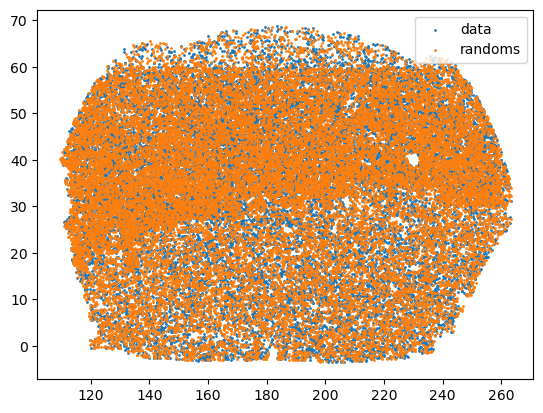

In [4]:
# Make a scatter plot of data RA/Dec and a histogram of data redshifts
# Check that weighted randoms have the same angular (RA/Dec) and redshift (Z) distribution as the data
from matplotlib import pyplot as plt
# Tip: for the RA/Dec plot, downsample the data and randoms for faster plots:
rng = np.random.RandomState(seed=42)
mask_data = rng.uniform(0., 1., len(data)) < 0.1
mask_randoms = rng.uniform(0., 1., len(randoms)) < mask_data.sum() / len(randoms)
# Then, e.g. plt.scatter(data['RA'][mask_data], data['DEC'][mask_data], s=1, label='data')
plt.scatter(data['RA'][mask_data], data['DEC'][mask_data], s=1, label='data')
plt.scatter(randoms['RA'][mask_randoms], randoms['DEC'][mask_randoms], s=1, label='randoms')
plt.legend()
plt.show()

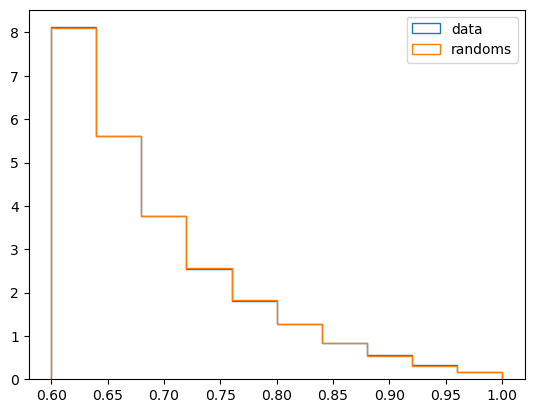

In [5]:
# Define the total completeness weights
for catalog in [data, randoms]:
    catalog['WEIGHT_COMP'] = catalog['WEIGHT_SYSTOT'] * catalog['WEIGHT_CP'] * catalog['WEIGHT_NOZ']

plt.hist(data['Z'], weights=data['WEIGHT_COMP'], histtype='step', density=True, label='data')
plt.hist(randoms['Z'], weights=randoms['WEIGHT_COMP'], histtype='step', density=True, label='randoms')
plt.legend()
plt.show()

Let's first transform redshifts Z into distances, assuming a fiducial cosmology. Take BOSS (and eBOSS) fiducial cosmology:
$\Omega_{m} = 0.31$, $\omega_{b} = 0.022$, $h = 0.676$, $\sigma_{8} = 0.8$, $n_{s} = 0.97$, $\sum m_{\nu} = 0.06 \; \mathrm{eV}$.

In [6]:
# Fiducial cosmological parameters are:
# dict(Omega_m=0.31, omega_b=0.022, h=0.676, sigma8=0.8, n_s=0.97)
# To compute comoving_radial_distance(z), various options:
# 1) code this yourself if you have never done so! You just need \Omega_{m} (flat Universe, negligible radiation: \Omega_{\Lambda} = 1 - \Omega_{m})
# H(z) = H_{0} \sqrt{\Omega_{m} (1 + z)^3 + \Omega_{\Lambda}}
# d(z) = \int cdz / H(z)
# WARNING: let's work in Mpc/h units (H0 = 100 h km/s/Mpc)
# NOTE: In Google Collab, you can try to ask the AI...
# 2) use classy, camb, astropy...
# 3) use cosmoprimo (engine='class' or 'camb' or 'astropy'), see cell 9 of https://github.com/cosmodesi/cosmoprimo/blob/main/nb/examples.ipynb
from cosmoprimo import Cosmology
cosmo_fid = Cosmology(Omega_m=0.31, omega_b=0.022, h=0.676, sigma8=0.8, n_s=0.97, m_ncdm=[0.06], engine='class')
# Or simply (using pre-defined fiducial cosmology)
#from cosmoprimo.fiducial import BOSS
#cosmo_fid = BOSS(engine='class')

def get_xyz(ra, dec, z):
    # Compute distance d
    d = cosmo_fid.comoving_radial_distance(z)
    # Turn distance d, RA (\phi), Dec (\pi/2-\theta) (mind degree -> radians!) into x, y, z Cartesian positions
    conv = np.pi / 180.
    theta, phi = dec * conv, ra * conv
    x = d * np.cos(phi) * np.cos(theta)
    y = d * np.sin(phi) * np.cos(theta)
    z = d * np.sin(theta)
    return x, y, z

data_positions = get_xyz(data['RA'], data['DEC'], data['Z'])
# Same for randoms
randoms_positions = get_xyz(randoms['RA'], randoms['DEC'], randoms['Z'])

For fun, make a 'wedge plot' of the data: a Cartesian 2D (x, y) slice between 0 and 1 deg in Dec. Do you see structures, filaments, voids?

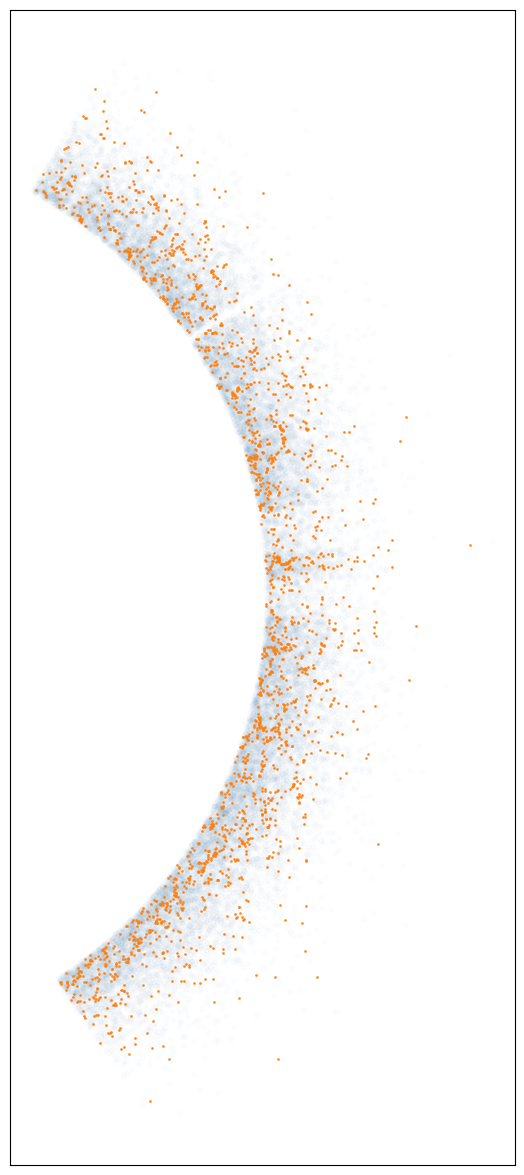

In [7]:
lim_dec = (0., 1.)
mask_data = (data['DEC'] > lim_dec[0]) & (data['DEC'] < lim_dec[1])
mask_randoms = (randoms['DEC'] > lim_dec[0]) & (randoms['DEC'] < lim_dec[1])

plt.gcf().set_size_inches((15,) * 2)
ax = plt.gca()
ax.set_aspect('equal')
# Plot (-x, y) (minus sign just to orient the figure)
ax.scatter(- randoms_positions[0][mask_randoms], randoms_positions[1][mask_randoms], marker='.', s=40., alpha=0.01)
ax.scatter(- data_positions[0][mask_data], data_positions[1][mask_data], marker='.', s=4., alpha=0.8)
ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False) 
plt.show()

In addition to completeness weights above, when computing 2pt statistics (correlation function or power spectrum), one can apply weights to minimize its variance: WEIGHT_FKP = 1/(1 + NZ * P0), with P0 the typical value of the power spectrum at the scales of interest, e.g. $10000 \; (\mathrm{Mpc}/h)^{3}$ (NZ is in $(\mathrm{Mpc}/h)^{-3}$).
See e.g. https://arxiv.org/pdf/astro-ph/9304022.pdf, eq. 2.3, for the variational demonstration (another, broader point-of-view is that of the optimal quadratic estimator, of which the FKP estimator we will use below is a simplification under some assumptions).

In [8]:
# Compute data weights, WEIGHT_COMP * WEIGHT_FKP
data_weights = data['WEIGHT_COMP'] * data['WEIGHT_FKP']
# Same for randoms
randoms_weights = randoms['WEIGHT_COMP'] * randoms['WEIGHT_FKP']

## Correlation function

### Pair counts as a function of $(s, \mu)$

Correlation functions are usually estimated by binning the (weighted) number of pairs of particles (galaxies, randoms) as a function of the distance $s = |\mathbf{r}_2 - \mathbf{r}_1|$ between particles (and optionally the cosine angle to the line-of-sight $\mu = \hat{\mathbf{s}} \cdot \widehat{(\mathbf{r}_2 + \mathbf{r}_1) / 2} = \mathbf{s} \cdot (\mathbf{r}_2 + \mathbf{r}_1) / (s |\mathbf{r}_1 + \mathbf{r}_2|))$.

This is basically a double loop, schematically:
```
for i1 in range(n1):  # loop over particles (positions, weights) of catalog 1
    for i2 in range(n2):  # loop over particles (positions, weights) of catalog 2
        wcounts[index(s(i1, i2)), index(mu(i1, i2))] += weight(i1, i2)
```
If you have enough time, you can give it a try with Python / numba; on Google Colab to start with you can e.g. ask the AI for "compute number of pair of points as a function of separation in 3D and cosine angle mu of the pair with respect to the midpoint line of sight, accelerate with numba
" (NOTE: be careful! the code may not be correct!). Compute the pair counts of galaxies ```data_positions1``` with weights ```data_weights1```, $s$-edges ```np.linspace(0., 200, 51)``` and $\mu$-edges ```np.linspace(-1., 1., 100)```. Downsample ```data_positions``` by a factor ~10 for the test --- how long without downsampling?

In [9]:
import numba as nb

@nb.njit(parallel=True)
def get_pair_counts(sedges, muedges, positions1, weights1, positions2, weights2):
    """
    Compute number of pair of points as a function of separation in 3D and cosine angle mu of the pair with respect to the midpoint line of sight, accelerate with numba.
    
    Parameters
    ----------
    sedges : array of shape (Ns + 1, )
        Bin edges for the distance.
    muedges : array of shape (Nmu + 1, )
        Bin edges for the cosine angle.
    positions1 : array of shape (N1, 3)
        Cartesian positions of points in the first catalog.
    weights1 : array of shape (N1, )
        Weights of points in the first catalog.
    positions2 : array of shape (N2, 3)
        Cartesian positions of points in the second catalog.
    weights2 : array of shape (N2, )
        Weights of points in the second catalog.
        
    Returns
    -------
    counts : array of shape (Ns, Nmu)
        Number of pairs in each separation bin.
    """
    n1 = positions1.shape[0]
    n2 = positions2.shape[0]
    wcounts = np.zeros((sedges.shape[0] - 1, muedges.shape[0] - 1), dtype='f8')
    
    for i1 in nb.prange(n1):
        for i2 in range(n2):
            diff = positions2[i2] - positions1[i1]
            s2 = np.sum(diff**2)
            if s2 > sedges[-1]**2 or s2 <= sedges[0]**2: continue
            s = np.sqrt(s2)
            los = (positions1[i1] + positions2[i2])
            mu = np.sum(diff * los) / (s * np.sqrt(np.sum(los**2)))
            #if mu > muedges[-1] or mu < muedges[0]: continue
            #sindex = np.searchsorted(sedges, s) - 1
            #muindex = np.searchsorted(muedges, mu) - 1
            sindex = int((s - sedges[0]) / (sedges[1] - sedges[0]))  # faster for linear bins
            muindex = int((mu - muedges[0]) / (muedges[1] - muedges[0]))
            wcounts[sindex, muindex] += weights1[i1] * weights2[i2]
            
    return wcounts

In [10]:
%%time
sedges = np.linspace(0., 200, 51)
muedges = np.linspace(-1., 1., 100)  # s, mu binning

# Downsample by a factor 10
positions, weights = np.column_stack(data_positions)[::10], data_weights
wcounts = get_pair_counts(sedges, muedges, positions, weights, positions, weights)

CPU times: user 54.9 s, sys: 66.6 ms, total: 55 s
Wall time: 9.08 s


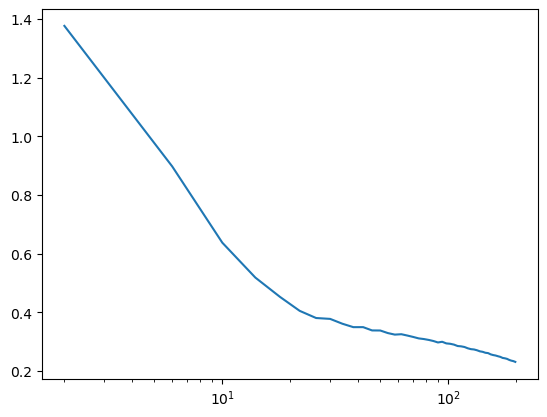

In [11]:
# Plot pair counts
s = (sedges[:-1] + sedges[1:]) / 2.
counts = np.sum(wcounts, axis=-1)
plt.plot(s, counts / (sedges[1:]**3 - sedges[:-1]**3))
plt.xscale('log')
plt.show()

For n1 ~ n2 ~ O(1e6) objects (or more, see e.g. the size of the random catalog), this will be slow (especially in Python only). How to speed this up?
Auto pair counts (particles i1 and i2 come from the same catalog) can be computed ~ twice faster than cross pair counts (particles i1 and i2 come from different catalogs), why?

**Answer**: To speed up, bin the particles into Cartesian cells. Only pairs of cells than are closer than the maximum distance are visited.
Auto pair counts means the second loop can be restricted to i2 $>=$ i1. Also, code in C!

Let's run with pycorr/Corrfunc. Pair counting is coded in C.

In [12]:
# Compute data - data pair counts DD
# You can use pycorr (wrapping a modified version of Corrfunc)
# If so, take a quick look at https://github.com/cosmodesi/pycorr/blob/main/nb/basic_examples.ipynb
edges = (np.linspace(0., 200, 51), np.linspace(-1., 1., 100))  # s, mu binning
nthreads, gpu = 4, False
# When running on Google Colab, you can use GPU:
#nthreads, gpu = 1, True
from pycorr import TwoPointCounter
# If positions are x, y, z, pass position_type='xyz' instead
D1D2 = TwoPointCounter(mode='smu', edges=edges, positions1=data_positions, weights1=data_weights,
                       position_type='xyz', dtype='f8', engine='corrfunc', nthreads=nthreads, gpu=gpu)
# D1D2.sep are (average) separations
# D1D2.wcounts are pair counts (weighted by the product of particle weights)
# D1D2.wnorm is the normalization (see below)
# Same for randoms - randoms pair counts RR
# WARNING: There are 10x more randoms than data; this will take a few minutes!
# To speed up the calculation in this notebook, let's downsample randoms_positions, randoms_weights
# You can forget the two lines below if you are ok to wait ~5/6 minutes (more ~20 min on Google Colab)
mask = rng.uniform(0., 1., len(randoms)) < 1. / 4.
randoms_positions, randoms_weights = [p[mask] for p in randoms_positions], randoms_weights[mask]
R1R2 = TwoPointCounter(mode='smu', edges=edges, positions1=randoms_positions, weights1=randoms_weights,
                       position_type='xyz', dtype='f8', engine='corrfunc', nthreads=nthreads, gpu=gpu)

/local/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Can you guess how RR counts typically evolve as a function of $s$ at small separation? This relation is not perfectly verified at small scales, due to fine-grained veto masks, but why is it really not valid anymore at large scales?

You see now why randoms are important!

**Answer**: The number of pairs typically increases with separation $s$ as the volume of the spherical shell of width $ds$, i.e. $s^2 ds$. Yet, it drops at large scale due to finite survey size / non-periodic boundary conditions (window function): there exists no pair of galaxies seperated by a distance larger than the survey size.

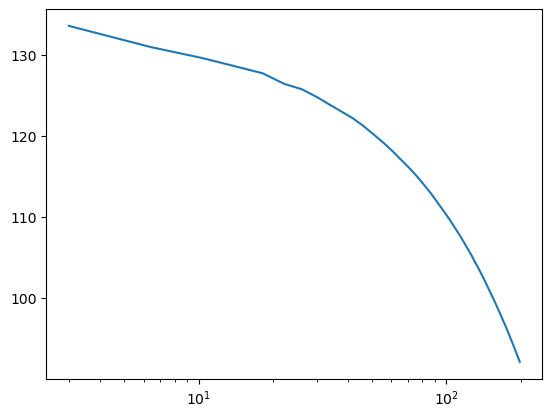

In [13]:
# Plot RR(s) / f(s) counts as a function of s
# (let's sum wcounts over mu to keep only the s-dependence)
s, counts, sedges = np.mean(R1R2.sep, axis=-1), np.sum(R1R2.wcounts, axis=-1), R1R2.edges[0]
plt.plot(s, counts / (sedges[1:]**3 - sedges[:-1]**3))
plt.xscale('log')
plt.show()

### Natural estimator
The natural estimator (the simplest one can typically think of) for the correlation function compares the (weighted) number of galaxy pairs to that of randoms (what we would have in absence of clustering), i.e. DD / RR - 1, with:
- DD the (normalized) galaxy - galaxy pair counts
- RR the (normalized) randoms - randoms pair counts

Why 'normalized'? What is the normalization factor?
Clue: what is the total (weighted) number of pairs (up to infinite separation)?

**Answer**: The normalization factor rescales RR (randoms are more numerous than data, to avoid increasing shot noise) to DD.

In [14]:
# Compute DD / RR - 1
# WARNING: you need to normalize DD and RR first before computing DD / RR - 1!
D1D2_wnorm = np.sum(data_weights)**2 - np.sum(data_weights**2)
R1R2_wnorm = np.sum(randoms_weights)**2 - np.sum(randoms_weights**2)
xi = (D1D2.wcounts / D1D2_wnorm) / (R1R2.wcounts / R1R2_wnorm) - 1
# Compute sep, mean s
sep = np.sum(R1R2.sep * R1R2.wcounts, axis=-1) / np.sum(R1R2.wcounts, axis=-1)

### Multipoles of the correlation function
Compute and plot the correlation function multipoles $\ell = 0$ (monopole), $\ell = 2$ (quadrupole) and $\ell = 4$ (hexadecapole), given by $\xi_{\ell}(s) = \frac{2 \ell + 1}{2} \int_{-1}^{1} d\mu \xi(s,\mu) \mathcal{L}_{\ell}(\mu)$,
with $\mathcal{L}_{\ell}(\mu)$ Legendre polynomials (see https://en.wikipedia.org/wiki/Legendre_polynomials, also https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.legendre.html).

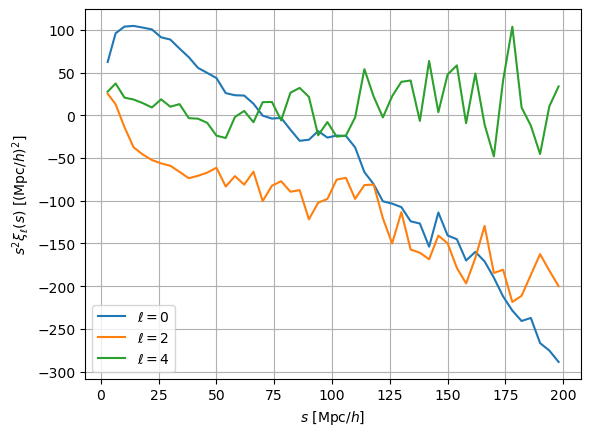

In [15]:
# Trick: write d\mu \mathcal{L}_{\ell}(\mu) as the difference of \mathcal{L}_{\ell}(\mu) primitives
# This makes sure $\xi_{\ell > 0} is 0 in case $\xi(s, \mu)$ is constant in \mu
ells = (0, 2, 4)
# Compute xiell, list of multipoles
from scipy import special
xiell = []
for ell in ells:
    muedges = R1R2.edges[1]
    poly = special.legendre(ell).integ()(muedges)
    legendre = (2 * ell + 1) * (poly[1:] - poly[:-1])
    xiell.append(np.sum(xi * legendre, axis=-1) / (muedges[-1] - muedges[0]))

# Plot the correlation function multipoles
for ill, ell in enumerate(ells):
    plt.plot(sep, sep**2 * xiell[ill], label='$\ell = {:d}$'.format(ell))
plt.grid(True)
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^{2}\xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend()
plt.show()

[000000.00]  08-14 21:16  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000000.00]  08-14 21:16  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[000000.00]  08-14 21:16  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000002.56]  08-14 21:17  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000018.96]  08-14 21:17  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 18.96 s.


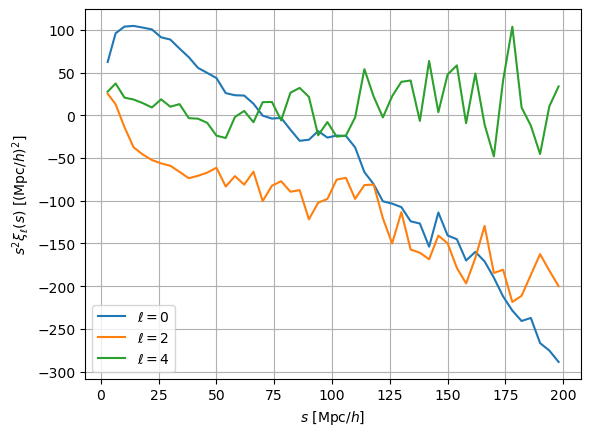

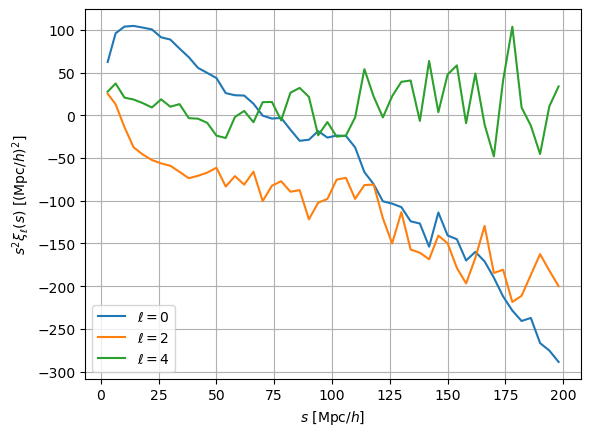

In [16]:
# Notes about pycorr
# You can obtain this directly with:
from pycorr import NaturalTwoPointEstimator
estimator = NaturalTwoPointEstimator(D1D2=D1D2, R1R2=R1R2)
s, xiell = estimator(ells=ells, return_sep=True)
estimator.plot(ells=ells)
# Or, starting from the beginning:
from pycorr import TwoPointCorrelationFunction, setup_logging
setup_logging()  # to activate logging
estimator = TwoPointCorrelationFunction(mode='smu', edges=edges, data_positions1=data_positions, data_weights1=data_weights,
                                        randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                        estimator='natural', position_type='xyz', dtype='f8', engine='corrfunc', nthreads=nthreads, gpu=gpu)
estimator.plot(ells=ells)
plt.show()

The monopole looks odd (does not go to ~ zero) on large scales!

No worries, this is not a bias (in average, it would be fine), but the natural estimator has a larger variance than the Landy-Szalay estimator (see e.g. https://articles.adsabs.harvard.edu/pdf/1993ApJ...412...64L): (DD - 2DR + RR) / RR.

Estimate the correlation function with the Landy-Szalay estimator.

In [17]:
# You can compute all pair counts DD, DR and RR as above
# Or use pycorr's general interface (see https://github.com/cosmodesi/pycorr/blob/main/nb/basic_examples.ipynb)
from pycorr import TwoPointCorrelationFunction
estimator = TwoPointCorrelationFunction(mode='smu', edges=edges, data_positions1=data_positions, data_weights1=data_weights,
                                        randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                        estimator='landyszalay', position_type='xyz', dtype='f8', engine='corrfunc', nthreads=nthreads, gpu=gpu)

[000019.55]  08-14 21:17  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000019.55]  08-14 21:17  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[000019.55]  08-14 21:17  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000021.69]  08-14 21:17  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000030.41]  08-14 21:17  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000045.01]  08-14 21:17  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 25.46 s.


Plot the correlation function multipoles. Looks better!  
You should clearly see the BAO peak (where?).
What does the non-zero quadrupole mean? Where does it come from?

You can also compare data to a theory correlation function (just scale the linear correlation function by an arbitrary factor).

**Answer**: BAO peak around $100 \; \mathrm{Mpc}/h$. Non-zero quadrupole = anistropy, coming from RSD.

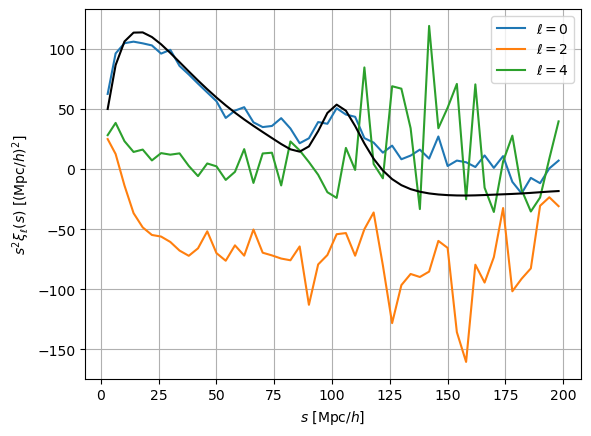

In [18]:
# Plot
estimator.plot(ells=ells)
zeff = np.average(data['Z'], weights=data_weights)  # (quite arbitrary) effective redshift

# Linear (real-space) correlation function:
# xi = cosmo_fid.get_fourier().pk_interpolator().to_1d(z=zeff).to_xi()(sep)
kaiser_factor = 6.5  # scaling by hand, just to match the amplitude
xi_model = kaiser_factor * cosmo_fid.get_fourier().pk_interpolator().to_1d(z=zeff).to_xi()(sep)
plt.plot(sep, sep**2 * xi_model, color='k')
plt.show()

## Power spectrum

Computing pair counts for correlation function estimation remains somewhat slow (still tractable for current surveys, DESI, Euclid). Also, theorists tend to prefer thinking in terms of the power spectrum, as different $k$-modes are initially (almost) uncorrelated and evolve independently in the linear regime (see Julien's course).
Let's compute the power spectrum monopole step-by-step, to show how this works.

First, "paint" data and randoms to a 3D mesh, to get an estimate of the 3D over density field $F(\mathbf{r}) = n_{d}(\mathbf{r}) - \alpha n_{r}(\mathbf{r})$, with:
- $n_{d}(\mathbf{r})$ the data density
- $n_{r}(\mathbf{r})$ the randoms density
- $\alpha = \sum_{i \in \mathrm{data}} w_{i} / \sum_{i \in \mathrm{randoms}} w_{i}$: scale the randoms density to the data density, i.e. such that $\int d^3 r F(\mathbf{r}) = 0$ (integral constraint!)

In [19]:
from pypower import CatalogMesh
# This step involves a kernel (resampler='tsc') that effectively smoothes the density field,
# which must be compensated for by a kernel in Fourier space (compensate=True),
# see e.g. https://arxiv.org/abs/astro-ph/0409240
# Wider is this kernel, better is the mitigation of aliasing effects (greater than Nyquist frequencies contaminating lower frequencies)
# Another technique to mitigate aliasing is 'interlacing': shifting the mesh by a fraction of mesh cell size
# see e.g. https://arxiv.org/abs/1512.07295
# WARNING: If you have < 8 GB RAM, use smaller nmesh (and / or dtype='f4' i.e. simple precision)
mesh = CatalogMesh(data_positions=data_positions, data_weights=data_weights,
                   randoms_positions=randoms_positions, randoms_weights=randoms_weights,
                   boxsize=5000., nmesh=256, resampler='tsc', interlacing=3, position_type='xyz',
                   dtype='f8', mpiroot=0)
# Paint data / randoms to mesh
rfield = mesh.to_mesh(compensate=True)
# To estimate the density, divide by the cell volume:
cellsize = mesh.boxsize / mesh.nmesh
dv = cellsize.prod()
rfield /= dv

[000047.53]  08-14 21:17  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 255741.
[000047.76]  08-14 21:17  CatalogMesh                  INFO     Painted 255741 out of 255741 objects to mesh.
[000047.77]  08-14 21:17  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 658945.
[000048.15]  08-14 21:17  CatalogMesh                  INFO     Painted 658945 out of 658945 objects to mesh.
[000048.15]  08-14 21:17  CatalogMesh                  INFO     Running interlacing at order 3.
[000048.70]  08-14 21:17  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 255741.
[000048.90]  08-14 21:17  CatalogMesh                  INFO     Painted 255741 out of 255741 objects to mesh.
[000048.91]  08-14 21:17  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 658945.
[000049.28]  08-14 21:17  CatalogMesh                  INFO     Painted 658945 out of 658945 objects to mesh.
[000050.11]  08-14 21:17  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 255741.
[000050.3

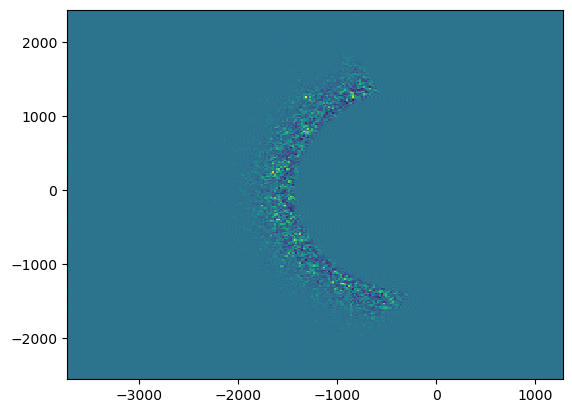

In [20]:
# Plot a z-slice of the mesh
coords = [cellsize[i] * np.arange(mesh.nmesh[i]) + mesh.boxcenter[i] - mesh.boxsize[i] / 2. for i in range(mesh.nmesh.size)]
plt.pcolormesh(*coords[:2], rfield[:, :, 100:110].sum(axis=-1).T)
plt.show()

Next, the power spectrum is (up to some normalization A), the square modulus of the Fourier-space field:
$\hat{P}(\mathbf{k}) = |F(\mathbf{k})|^2 / A - S$.

In [21]:
# Compute F(k)
cfield = rfield.r2c()  # Fast Fourier Transform, F(r) -> F(k)
# FFT convention is F(k) = 1/N^3 \sum_{r} e^{-ikr} F(r), so compensate by N^3 * dv
cfield *= mesh.nmesh.prod() * dv
cfield[...] = cfield[...] * cfield[...].conj()  # |F(k)|^2
del rfield  # save memory
#print(cfield.value[0, 0, 0])  0 by construction: integral constraint!

We want to compute the 1D power spectrum, as a function of the norm $k = |\mathbf{k}|$. Let's bin $|F(\mathbf{k})|^2$ as a function of  $k = |\mathbf{k}|$.

In [22]:
# edges = (k-edges, mu-edges = [-1, 1])
knyq = np.pi / np.max(cellsize)  # Nyquist frequency
edges = (np.arange(0., knyq, 0.005), np.linspace(-1., 1., 2))
from pypower.fft_power import project_to_basis
k, _, pk, nk, _ = project_to_basis(cfield, edges)[0]
k, pk = k.ravel(), pk.ravel().real
del cfield  # save memory

Let's find the normalization $A = \int d^3 r \bar{n}^2(\mathbf{r})$, with $\bar{n}$ the selection function (sampled by the randoms).

In [23]:
# Trick: estimate \bar{n}^2 with data x randoms instead of randoms^2 to avoid shot noise
wnorm = (mesh.to_mesh(field='data', compensate=False) / dv * mesh.to_mesh(field='data-normalized_randoms', compensate=False) / dv).csum() * dv
pk /= wnorm

[000054.20]  08-14 21:17  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 255741.
[000054.41]  08-14 21:17  CatalogMesh                  INFO     Painted 255741 out of 255741 objects to mesh.
[000054.41]  08-14 21:17  CatalogMesh                  INFO     Running interlacing at order 3.
[000054.95]  08-14 21:17  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 255741.
[000055.16]  08-14 21:17  CatalogMesh                  INFO     Painted 255741 out of 255741 objects to mesh.
[000055.99]  08-14 21:17  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 255741.
[000056.19]  08-14 21:17  CatalogMesh                  INFO     Painted 255741 out of 255741 objects to mesh.
[000057.78]  08-14 21:17  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 658945.
[000058.15]  08-14 21:17  CatalogMesh                  INFO     Painted 658945 out of 658945 objects to mesh.
[000058.15]  08-14 21:17  CatalogMesh                  INFO     Running interlacing at order 3.
[000

Plot the power spectrum (typically $k P(k)$). What is its unit?
The small scales (high $k$) monopole looks fishy (too high --- it should ~ decrease), did we forget anything?

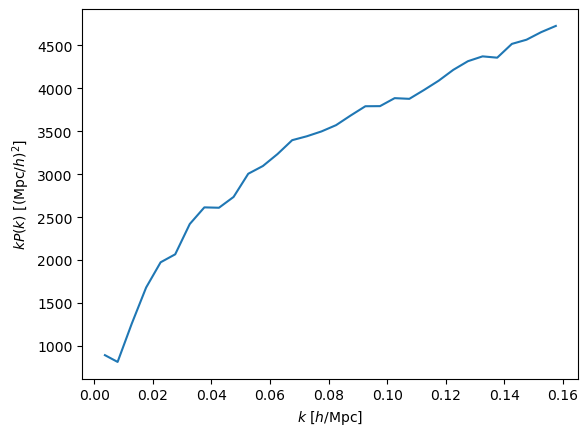

In [24]:
# Plot
plt.plot(k, k * pk)
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

Indeed, we forgot to remove the Poisson shot noise $S$! What is it?

$S$ is to be computed as $(\sum_{i \in \mathrm{data}} w_{i}^{2} + \alpha^2 \sum_{i \in \mathrm{randoms}} w_{i}^{2}) / A$.
Subtract it from the estimated power spectrum, and plot the result.

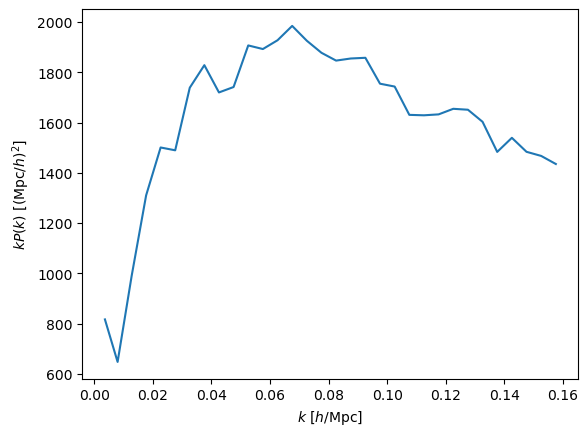

In [25]:
# Plot
alpha = np.sum(data_weights) / np.sum(randoms_weights)
shotnoise = (np.sum(data_weights**2) + alpha**2 * np.sum(randoms_weights**2)) / wnorm
plt.plot(k, k * (pk - shotnoise))
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

Looks much better! Do you recognize the BAO wiggles? To see them better, you can compare data to a theory power spectrum.

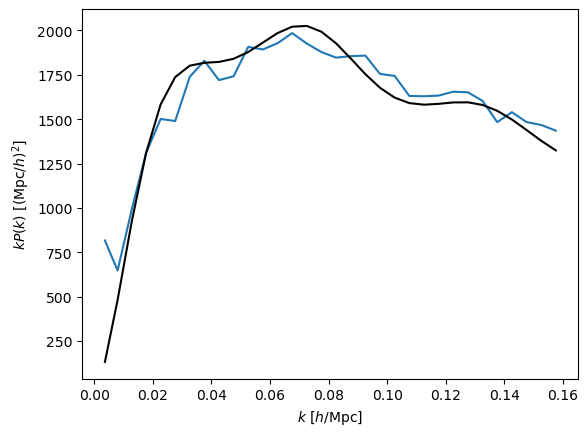

In [26]:
# Plot
pk_model = kaiser_factor * cosmo_fid.get_fourier().pk_interpolator().to_1d(z=zeff)(k)
plt.plot(k, k * (pk - shotnoise))
plt.plot(k, k * pk_model, color='k')
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

### Multipoles of the power spectrum
Estimating higher multipoles (quadrupole, hexadecapole) is slightly more difficult, as we have to account for varying line-of-sight. We typically use the first-point / end-point for line-of-sight $\hat{\mathbf{\eta}} = \hat{\mathbf{r}}_{2}$, to split:
$\hat{P}(\mathbf{k}) = (2\ell + 1) / A \sum_{\mathbf{r}_{1}, \mathbf{r}_{2}} e^{ik(\mathbf{r}_{2} - \mathbf{r}_{1})} F(\mathbf{r}_{1}) F(\mathbf{r}_{2}) \mathcal{L}_{\ell}(\hat{\mathbf{k}} \cdot \hat{\mathbf{\eta}}) - \delta_{\ell 0} S$
into:
$\hat{P}(\mathbf{k}) = (2\ell + 1) / A F_{\ell}^{\star}(\mathbf{k}) F_{0}(\mathbf{k}) - \delta_{\ell 0} S$
with:
$F_{\ell}(\mathbf{k}) = \sum_{\mathbf{r}} e^{i\mathbf{k} \cdot \mathbf{r}} F(r) \mathcal{L}_{\ell}(\hat{\mathbf{k}} \cdot \hat{\mathbf{r}})$.
This last term can be split, using e.g. decomposition of Legendre polynomial into spherical harmonics, into a pure $\mathbf{k}$-dependent term, times a standard Fourier transform, which can be FFT'ed. See e.g. https://arxiv.org/abs/1704.02357.

In [27]:
# For this, use pypower.
# (You can take a quick look at https://github.com/cosmodesi/pypower/blob/main/nb/basic_examples.ipynb)
from pypower import CatalogFFTPower
power = CatalogFFTPower(data_positions1=data_positions, data_weights1=data_weights,
                        randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                        boxsize=5000., nmesh=256, resampler='tsc', interlacing=3,
                        edges={'step': 0.005}, ells=(0, 2, 4), position_type='xyz', dtype='f8', mpiroot=0).poles

[000062.74]  08-14 21:18  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[256 256 256], boxsize=[5000. 5000. 5000.], boxcenter=[-1214.52534061   -47.66296078   979.04264351], dtype=float64).
[000062.82]  08-14 21:18  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 255741.
[000063.04]  08-14 21:18  CatalogMesh                  INFO     Painted 255741 out of 255741 objects to mesh.
[000063.05]  08-14 21:18  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 658945.
[000063.43]  08-14 21:18  CatalogMesh                  INFO     Painted 658945 out of 658945 objects to mesh.
[000063.43]  08-14 21:18  CatalogMesh                  INFO     Running interlacing at order 3.
[000063.98]  08-14 21:18  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 255741.
[000064.19]  08-14 21:18  CatalogMesh                  INFO     Painted 255741 out of 255741 objects to mesh.
[000064.20]  08-14 21:18  CatalogMesh                  INFO     Slab 0 ~ 4

Plot the power spectrum multipoles.
Again, BAO wiggles and non-zero quadrupole!

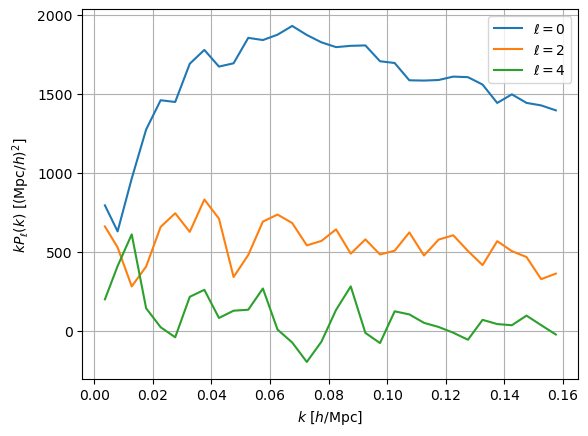

In [28]:
# Plot
power.plot()
plt.show()

Note that the above power spectrum measurements (using the 'FKP estimator') cannot (should not) be directly compared to theory power spectrum models... Indeed, in these measurements the power spectrum is convolved with the survey selection function (that we essentially already removed in the correlation function estimation with the division by RR). Therefore, usually people multiply the theory power spectrum by the window matrix, which can be computed from the random catalogs; see https://github.com/cosmodesi/pypower/blob/main/nb/window_examples.ipynb if you are interested.

### Kaiser formula
Still, let's just look how the power spectrum multipoles compare to the Kaiser formula, which gives the expected power spectrum at linear order (i.e. accurate on large scales = low $k$):
$P(k, \mu) = (b_{1} + f \mu^2)^{2} P^{\mathrm{lin}}_{\delta\delta}(k) = (\beta^{-1} + \mu^2)^{2} P^{\mathrm{lin}}_{\theta\theta}(k)$ ($\beta = f / b_{1}$)
where $b_{1}$ is the (linear) galaxy bias, $f = \frac{d\ln{D}}{d\ln{a}} \simeq \Omega_m(z)^{0.55}$ is the logarithmic growth rate of structure, $P^{\mathrm{lin}}_{\delta\delta}(k)$ is the linear power spectrum.

The model depends on $f (\times \sigma_{8})$ or --- better formulated --- the amplitude of the velocity divergence power spectrum $P_{\theta\theta}(k)$, which we can fit to the data.

Integrate $P(k, \mu)$ over Legendre polynomials, either symbolically (easy!) or by numerical integration, and plot model and data.

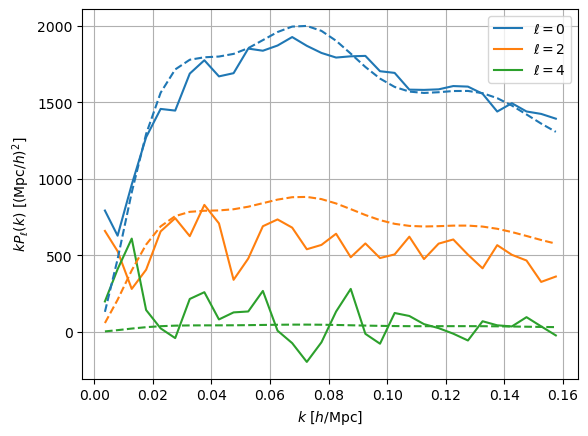

In [29]:
pklin = cosmo_fid.get_fourier().pk_interpolator()(k, z=zeff)
f = cosmo_fid.growth_rate(zeff)
b = 2.25  # tune by hand to match data amplitude
pk_model = []
# Monopole:
pk_model.append((b**2 + 2. / 3. * b * f + 1. / 5. * f**2) * pklin)
pk_model.append((4. / 3. * b * f + 4. / 7. * f**2) * pklin)
pk_model.append(8. / 35 * f**2 * pklin)
# Append the quadrupole and hexadecapole
power.plot()
for ill, ell in enumerate(ells):
    plt.plot(k, k * pk_model[ill], color='C{:d}'.format(ill), linestyle='--')
plt.show()
# Or:
#pktt = cosmo_fid.get_fourier().pk_interpolator(of='theta_cb')(k, z=zeff)
#beta = cosmo_fid.growth_rate(zeff) / 2.25  # tune by hand
#pk_model = []
# Append the multipoles
#pk_model.append((1 / beta**2 + 2. / 3. / beta + 1. / 5.) * pktt)
#pk_model.append((4. / 3. / beta + 4. / 7.) * pktt)
#pk_model.append(8. / 35 * pktt)
#power.plot()
#for ill, ell in enumerate(ells):
#    plt.plot(k, k * pk_model[ill], color='C{:d}'.format(ill), linestyle='--')
#plt.show()

The quadrupole in particular looks a small scales (high $k$) a bit more damped in the data than in the model, why?

**Answer**: Finger-of-God effect.

## Take-home messages
- in standard analyses, the observed (RA, Dec, z) are compressed into power spectrum or correlation function multipoles
- BAO: peak at 100 $\mathrm{Mpc}/h$ in the correlation function, wiggles in the power spectrum
- measuring the position of the BAO peak = measuring a fixed comoving distance ('standard ruler') at a given redshift = constraing the Universe's expansion
- non-zero quadrupole = anisotropy (w.r.t the line-of-sight): redshift-space distortions (linear model: Kaiser formula)
- measuring redshift-space distortions = constraining the amplitude of the velocity power spectrum: growth of structure

## Bonus
- pen-and-paper exercise: derive the Kaiser formula, knowing that:
$\mathbf{s} = \mathbf{r} + v_{z} \hat{\mathbf{z}}$ with $v_{z}(\mathbf{k}) = - i f \mathbf{k} / k^{2} \delta_{r}(\mathbf{k})$ (which can be obtained from linear theory)
and mass conservation (mass in redshift space = mass in real space): $\left[1 + \delta_{s}(\mathbf{s})\right]d^{3}s = \left[1 + \delta_{r}(\mathbf{r})\right]d^{3}r$. Correction: Section II. of https://arxiv.org/abs/1006.0699.
- we have worked so far with 'pre-reconstruction' catalogs. A step called 'reconstruction' can be used to sharpen the BAO peak. Compute the correlation function and / or power spectrum of reconstructed catalogs (with *rec* in name).
Note that, in this case, you should provide reconstructed data for data_positions and data_weights, reconstructed randoms for shifted_positions and shifted_weights, and pre-reconstruction randoms for randoms_positions, randons_weights. What is the difference w.r.t. pre-reconstruction measurements? (BAO peak, quadrupole?).
- you can try applying reconstruction yourself to pre-reconstruction catalogs with https://github.com/cosmodesi/pyrecon
- here pair weights are simple product of galaxy individual weights... but we can imagine other schemes, e.g. to correctly compensate for fiber collisions: see https://github.com/cosmodesi/pycorr/blob/main/nb/pip_examples.ipynb (and similar correction for power spectrum, https://github.com/cosmodesi/pypower/blob/main/nb/pip_examples.ipynb)
- start Y2 TD, cosmological constraints with BAO: bao_inverse_distance_ladder.ipynb
- why are you still here? go to the beach...